In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from astropy.table import Table
t = Table.read('../../../../../../Downloads/vizier_votable(5).vot', format='votable')

print("Finished reading Table. Read ",len(t['__Gmag_'])," sources")

Finished reading Table. Read  503325  sources


In [3]:
print("The astropy reader loads the data into the following variable names:")
print(t.colnames)

The astropy reader loads the data into the following variable names:
['RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var']


In [4]:
RA = t['RA_ICRS']
DE = t['DE_ICRS']
plx = t['Plx']
num = len(RA)


In [5]:
X1 = np.zeros(num)
Y1 = np.zeros(num)
for i in range(0,num):
    X1[i] = RA[i]
    Y1[i] = DE[i]
X = np.column_stack((X1,Y1))
print(len(X))

503325


In [6]:
#compare stelllar densities in different regions
stars1 = 0
stars2 = 0

for i in range(len(RA)):
    if ( RA[i] > 249 and RA[i] < 249.5 and DE[i] > -23 and DE[i] < -22.5):
        stars1 = stars1 + 1
    if (RA[i] > 246.5 and RA[i] < 247 and DE[i] > -24.75 and DE[i] < -24.25):
        stars2 = stars2 + 1
density1 = stars1/(0.5*0.5)
density2 = stars2/(0.5*0.5)
    
        

In [7]:
print(density1)
print(density2)

31000.0
392.0


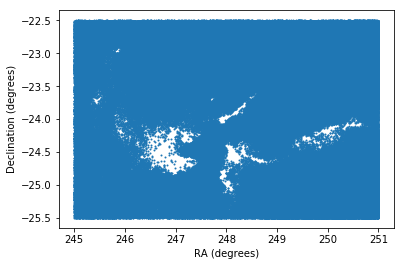

In [8]:
plt.scatter(RA,DE, s = 1)
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

In [9]:
RAmin = min(RA)
RAmax = max(RA)
DEmin = min(DE)
DEmax = max(DE)
RA_range = RAmax - RAmin
DE_range = DEmax - DEmin
area = RA_range*DE_range
num = len(RA)
density = num/area
print(RA_range)
print(DE_range)
print(area)
print(num)
print(density)

5.9999703714
2.9999811586
17.9997980664
503325
27962.8137018


In [10]:
#create mapping function
def distance_map(data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor, scatter, contour):
    from scipy.spatial import KDTree

    #use KD tree to find distances to nearest neighbor stars
    tree = KDTree(data)
    
    dRA = (RAmax - RAmin)/pixel_count
    dDE = (DEmax - DEmin)/pixel_count

    #create array of coordinates for image background
    for i in range(0,pixel_count):
        for j in range(0,pixel_count):
            if (i==0 and j == 0):
                array4 = np.array([RAmin,DEmin])
            else:
                array3 = [RAmin+i*dRA,DEmin+j*dDE]
                array4 = np.vstack((array4,array3))

    #find nearest neighbor distances to background points
    image = tree.query(array4,k=neighbor+1)

    #change array of background points so it is 100 x 100
    dist2 = image[0][:,neighbor-1]
    dist2 = np.resize(dist2,(pixel_count,pixel_count))
    dist2 = np.rot90(dist2, k=1, axes=(1,0))
    dist2 = np.fliplr(dist2)

    #display map 
    plt.imshow(dist2, origin='lower')
    if (scatter == True):
        plt.scatter(data[:,0],data[:,1],s = 2,c = 'b')
    if (contour == True):
        plt.contour(dist2, colors = ['m','lightpink','crimson','b'])
        plt.colorbar()
    plt.show()
    return

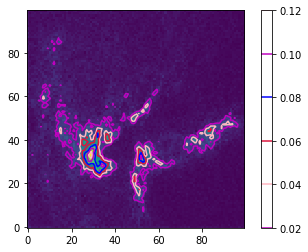

Elapsed time is: 7.422714654356241


In [11]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 100
scatter = False
contour = True
neighbor = 5

distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

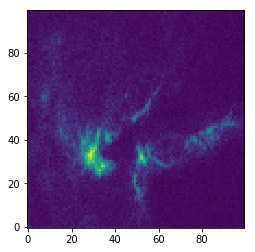

Elapsed time is: 7.1637846156954765


In [12]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 100
scatter = False
contour = False
neighbor = 5

distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

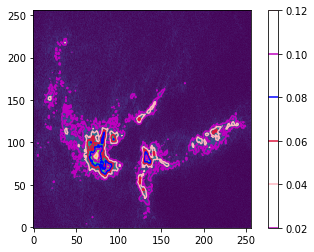

Elapsed time is: 34.377427872270346


In [13]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 256
scatter = False
contour = True
neighbor = 5

distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

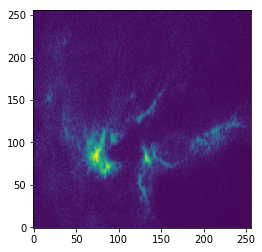

Elapsed time is: 34.18979365751147


In [14]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 256
scatter = False
contour = False
neighbor = 5

distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

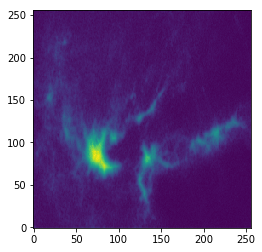

Elapsed time is: 48.821930322796106


In [15]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 256
scatter = False
contour = False
neighbor = 20

distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

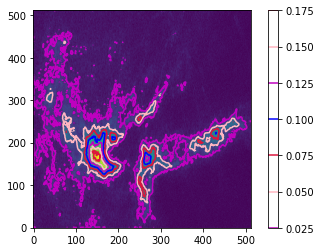

Elapsed time is: 234.29533524252474


In [16]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 512
scatter = False
contour = True
neighbor = 20

distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

In [ ]:
import matplotlib.mlab as mlab
from scipy.interpolate import Rbf
np.random.seed(1)

X, Y = np.meshgrid(np.arange(-3.0, 3.0, 0.1), np.arange(-2.4, 1.0, 0.1))
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
Z = 10.0 * (Z2 - Z1)

points = np.random.randn(15,2)/1.2
levels = [-1.2, -0.8,-0.4,-0.2]

# interpolate points
f = Rbf(X.flatten(), Y.flatten(), Z.flatten()) 
zi = f(points[:,0], points[:,1])
# add interpolated points to array with columns x,y,z
points3d = np.zeros((points.shape[0],3))
points3d[:,:2] = points
points3d[:,2] = zi
# masking condition for points between levels
filt = (zi>levels[1]) & (zi <levels[2])
# print points between the second and third level
print(points3d[filt,:])

### plotting
fig, ax = plt.subplots()

CS = ax.contour(X, Y, Z, levels=levels)
ax.clabel(CS, inline=1, fontsize=10)
#plot points between the second and third level in red:
ax.scatter(points[:,0], points[:,1], c=filt.astype(float), cmap="bwr" )

plt.show()

In [ ]:
import math
for i in range(0,100):
        for j in range(0,100):
            if (i==0 and j == 0):
                points2 = np.array([0,0])
            else:
                array = [i,j]
                points2 = np.vstack((points2,array))
z= np.zeros((100,100))
for x in range(0,100):
    for y in range(0,100):
        val = math.pow(x-50,2) +math.pow(y-50,2)
        z[x,y] = math.sqrt(val)
plt.imshow(z,origin = 'lower')
a = plt.contour(z, colors = ['m','lightpink','crimson'])
plt.colorbar()
plt.show()

print(a.levels)
num = 0
for i in range(0,100):
        for j in range(0,100):
            if (z[i,j] > 30 and z[i,j] < 40):
                num = num+1
print(num)

In [ ]:
#Find number of stars with parallaxes
parallaxes = np.array([])
plx_indices = np.array([])
for i in range(len(plx)):
    if (plx[i] > 0):
        parallaxes = np.append(parallaxes, plx[i])
        plx_indices = np.append(plx_indices, i)
print(len(parallaxes))
distances = 1000/parallaxes

#find index of outlier
for i in range(len(distances)):
    if (distances[i] > 40000):
        print(i)
        
#remove outlier
parallaxes  = np.delete(parallaxes, 61)
plx_indices = np.delete(plx_indices, 61)
distances = np.delete(distances, 61)
print(len(parallaxes))

In [ ]:
#Create subset of stars of known distances 
RA_dist = np.array([])
DE_dist = np.array([])
for i in plx_indices:
    j = int(i)
    RA_dist = np.append(RA_dist, RA[j])
    DE_dist = np.append(DE_dist, DE[j])
    
plt.hist(distances, bins = 60)
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Stars')

In [ ]:
plt.scatter(RA,DE, s = 1)
plt.scatter(RA_dist, DE_dist, s=1, c = 'k')
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

In [ ]:
plt.hist(distances, bins = 60)
plt.gca().set_xscale("log")
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Stars')

In [ ]:
plt.hist(distances, bins = 60, log = True)
plt.gca().set_xscale("log")
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Stars')

In [ ]:
plt.hist(np.log10(distances), bins = 60)
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Stars')

In [ ]:
plt.hist(distances, bins = 60)
plt.xlabel('Distance (pc)')
plt.ylabel('Distance ')

In [ ]:
count = 0
for i in range(len(distances)):
    if (distances[i] <= 140):
        print(distances[i])
        count = count +1
print(count)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(RA_dist,distances,DE_dist)
ax.
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Distance (pc)')
ax.set_zlabel('Declination (degrees)')

plt.show()

In [ ]:
plt.scatter(RA_dist, DE_dist)
plt.show()

In [ ]:
plt.scatter(RA_dist, distances)
plt.show()

In [ ]:
plt.scatter(DE_dist, distances)
plt.show()